In [46]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

In [47]:
def box_cornel(upleft,bxl,bxb):
    return [upleft,[upleft[0],upleft[1]+bxb-1],[upleft[0]+bxl-1,upleft[1]],[upleft[0]+bxl-1,upleft[1]+bxb-1]]

In [48]:
def cornel(upleft,bxl,bxb):
    return [upleft,[upleft[0],upleft[1]+bxb],[upleft[0]+bxl,upleft[1]],[upleft[0]+bxl,upleft[1]+bxb]]

In [49]:
def whole_upleft(tl,tr,bl, br,bxl,bxb):
    upleft_list=[]
    upleft_list += cornel(tl,-bxl,-bxb)
    upleft_list += cornel([tr[0],tr[1]-bxb+1],-bxl,+bxb)
    upleft_list += cornel([bl[0]-bxl+1,bl[1]],+bxl,-bxb)
    upleft_list += cornel([br[0]-bxl+1,br[1]-bxb+1],+bxl,+bxb)
    return upleft_list

In [50]:
def next_state(state,upleft,bxl,bxb):
    nx_state=state.copy()
    nx_state[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb]=1
    return nx_state

In [51]:
def feasible_location(state,whole_upleft_list,bxl,bxb,bxh=None,state_H=None,is2d=True):
    # state: current container, w_upleft: whole upleft list
    state_L=state.shape[0]
    state_B=state.shape[1]
    f_upleft=whole_upleft_list.copy()
    f_upleft = np.array(f_upleft)

    new_array = [tuple(row) for row in f_upleft]
    f_upleft = np.unique(new_array, axis=0)

    f_upleft=f_upleft[((f_upleft[:,0]>=0) & (f_upleft[:,1]>=0) & (f_upleft[:,0]+bxl<=state_L) & (f_upleft[:,1]+bxb<=state_B))]

    idx=[]
    if is2d:

        for i,[j,k] in  enumerate(f_upleft):
            if np.sum(state[j:j+bxl,k:k+bxb]) >=1: idx.append(i)
    else:
        for i,[j,k] in enumerate(f_upleft):
            if np.sum(state[j:j+bxl,k:k+bxb] != state[j,k] ) >= 1: idx.append(i)
            elif state[j,k]+bxh > state_H: idx.append(i)
    f_upleft=np.delete(f_upleft,idx,axis=0)
    return f_upleft

In [52]:
def action_options_list(f_upleft_list):
    action_options=[]
    for i,j in f_upleft_list:
        action_option=np.zeros((20,20))
        action_option[i,j]=1
        action_options.append(action_option)
    return action_options

In [53]:
class Bpp3DEnv():
    def __init__(self):
        super(Bpp3DEnv, self).__init__()
        self.length=20
        self.breadth=20
        self.height=20
        self.container=np.zeros((self.length,self.breadth))
        
    def step(self, upleft,bxl,bxb,bxh):
        self.container[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] += bxh 
        return self.container
    
    def reset(self):
        self.container=np.zeros((self.length,self.breadth))

    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)

In [54]:
container = np.zeros((20,20))
c_ct = container.copy()
w_upleft = whole_upleft(*box_cornel([0,0],20,20),1,2)
print(len(w_upleft))

16


In [55]:
c_ct=next_state(c_ct,[0,0],10,10)
w_upleft += whole_upleft(*box_cornel([0,0],10,10),1,2)
print(len(w_upleft))

32


In [56]:
c_ct=next_state(c_ct,[13,17],7,3)
w_upleft += whole_upleft(*box_cornel([13,17],7,3),1,2)
print(len(w_upleft))

48


In [57]:
def generation_2dbox(N_epi=1,c_l=20,c_b=20):
    #c_l, c_h: length, height
    np.random.seed(seed=100)
    epi_input=[]
    epi_gt_upleft=[]
    
    for i in range(N_epi):
        N_mdd=np.random.choice(list(range(25,30)), 1)
        
        X_input=[[c_l,c_b]]
        gt_upleft=[[0,0]]
        #X_input=[[int(c_l/2),int(c_b/2)]]*4 #4분할
        #gt_upleft=[[0,0],[int(c_l/2),0],[0,int(c_b/2)],[int(c_l/2),int(c_b/2)]]
        #N_mdd-=4
        
        while(len(X_input)<N_mdd):
            idx=np.random.choice(list(range(len(X_input))), 1)[0]#pop an item randomly from X_input
            pop_item=X_input.pop(idx)#[l, b]
            pop_gt_upleft=gt_upleft.pop(idx)
            idx=np.random.choice([0,1],1)[0]#choose an axis randomly
            
            if pop_item[idx]<=3:#if pop_item[idx]==1:
                X_input.append(pop_item)
                gt_upleft.append(pop_gt_upleft)
            else:#item split
                #pos=np.random.choice(list(range(1,pop_item[idx]-1)),1)[0]
                pos=np.random.choice(list(range(1+1,pop_item[idx]-1)),1)[0]#choose a position randomly - distance
                #item L,B
                item1=pop_item.copy()
                item2=pop_item.copy()
                item1[idx]=pos
                item2[idx]=pop_item[idx]-pos
                X_input+=[item1,item2]
                #gt upleft
                itme2_upleft=pop_gt_upleft.copy()
                itme2_upleft[idx] += pos
                gt_upleft+=[pop_gt_upleft,itme2_upleft]
        
        # 랜덤 순서
        #z = list(zip(X_input, gt_upleft))
        #shuffle(z)
        #X_input, gt_upleft = zip(*z)
        
        #크기순 정렬
        #s=[i*j for i,j in X_input]
        #s_idx=sorted(range(len(s)), key=lambda k: s[k])
        #X_input=np.array(X_input)[list(reversed(s_idx))]
        #gt_upleft=np.array(gt_upleft)[list(reversed(s_idx))]
        
        epi_input.append(X_input)
        epi_gt_upleft.append(gt_upleft)
    return epi_input,epi_gt_upleft#np.array(X_input)#_input

In [58]:
boxes,gt_tmp=generation_2dbox(N_epi=1,c_l=20,c_b=20)#N,2
boxes = boxes[0]
boxes

[[3, 3],
 [2, 3],
 [4, 17],
 [5, 3],
 [2, 2],
 [3, 17],
 [2, 3],
 [4, 3],
 [2, 17],
 [2, 17],
 [5, 9],
 [2, 6],
 [2, 3],
 [3, 3],
 [2, 2],
 [8, 3],
 [3, 3],
 [2, 3],
 [2, 3],
 [2, 3],
 [2, 6],
 [2, 3],
 [2, 3],
 [3, 2],
 [2, 2]]

In [59]:
box = boxes[0]
box

[3, 3]

In [60]:
f_upleft = feasible_location(c_ct,w_upleft, box[0], box[1])
len(f_upleft), f_upleft

(5,
 array([[ 0, 10],
        [ 9, 10],
        [10,  0],
        [10,  8],
        [10, 10]]))

In [61]:
def action_options_list(f_upleft_list):
    action_options=[]
    for i,j in f_upleft_list:
        action_option=np.zeros((20,20))
        action_option[i,j]=1
        action_options.append(action_option.flatten())
    return action_options

a_op=action_options_list(f_upleft)

In [62]:
len(a_op)

5

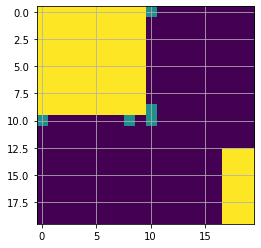

In [63]:
tmp=c_ct.copy()
for i in f_upleft: tmp[(i[0],i[1])] = 0.5
plt.imshow(tmp)
plt.grid()

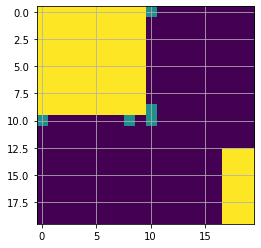

In [64]:
tmp=c_ct.copy()
for i in f_upleft: tmp[(i[0],i[1])] = 0.5
plt.imshow(tmp)
plt.grid()

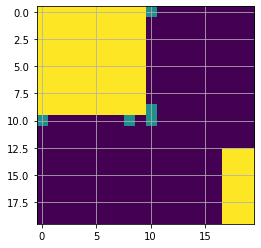

In [65]:
tmp=c_ct.copy()
for i in f_upleft: tmp[(i[0],i[1])] = 0.5
plt.imshow(tmp)
plt.grid()

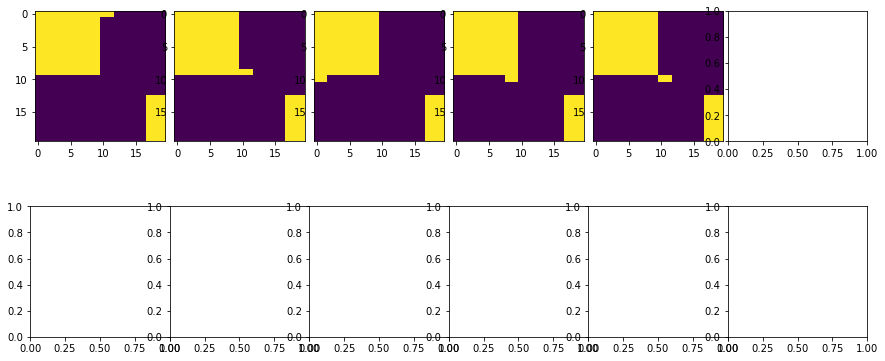

In [66]:
fig, axs = plt.subplots(2,6, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i=0
for r,c in f_upleft:
    tmp=c_ct.copy()
    tmp[r:r+1,c:c+2] = 1
    axs[i].imshow(tmp);i+=1

In [44]:
env = Bpp3DEnv()
env.reset()

In [45]:
import utils

In [70]:
import pickle
data = pickle.load('preprocessed_data/GA.pickle')

TypeError: file must have 'read' and 'readline' attributes

In [71]:
data

NameError: name 'data' is not defined